In [1]:
## This script is developed for the purpose of visualization 
## of the FARGO output
## This script combines the FARGO recommended script and the multifluid script developed by me

# Author: sayantan
# Date : 9 September 2019
# modified : 18 Spetember 2019
# modified : 20 September 2019 to include the condition for reduced output
# modified : 20 November 2019 to modify the polar plots with cartesian coordinates
# modified : 26 December 2019 to implement the parallel processing and subplot implementation.
# modified : 18 March 2020 to calculate all the gap widths and depth using the Dong et al model 2016


####### Importing the required modules

from pylab import*
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rc('text', usetex=True)
import os

#import time
# import glob
# from matplotlib import ticker, cm
# import cv2



In [2]:
## Making the Parameter class 
class Parameters(object):
    """
    Class for reading the simulation parameters.
    input: string -> name of the parfile, normally variables.par
    """
    def __init__(self, output_folder): 
        if len(output_folder) > 1:
            if output_folder[-1] != '/':
                output_folder += '/'
        try:
            params = open(output_folder +"variables.par",'r') #Opening the parfile
        except IOError:                  # Error checker.
            print  (paramfile + " not found.")
            return
        lines = params.readlines()     # Reading the parfile
        params.close()                 # Closing the parfile
        par = {}                       # Allocating a dictionary
        for line in lines:             #Iterating over the parfile
            name, value = line.split() #Spliting the name and the value (first blank)
            try:
                float(value)           # First trying with float
            except ValueError:         # If it is not float
                try:
                    int(value)         # we try with integer
                except ValueError:     # If it is not integer, we know it is string
                    value = '"' + value + '"'
            par[name] = value          # Filling the dictory
        self._params = par             # A control atribute, actually not used, good for debbuging
        for name in par:               # Iterating over the dictionary
            exec("self."+name.lower()+"="+par[name]) #Making the atributes at runtime

In [3]:
## Making the Mesh Class
class Mesh():
    """
    Mesh class, for keeping all the mesh data.
    Input: directory [string] -> this is where the domain files are.
    """
    def __init__(self, output_folder=""):
        if len(output_folder) > 1:
            if output_folder[-1] != '/':
                output_folder += '/'
        try:
            domain_x = np.loadtxt(output_folder+"domain_x.dat")
        except IOError:
            print("IOError with domain_x.dat")
        try:
            #We avoid ghost cells
            domain_y = np.loadtxt(output_folder+"domain_y.dat")[3:-3]
        except IOError:
            print ("IOError with domain_y.dat")
        self.xm = domain_x #X-Edge
        self.ym = domain_y #Y-Edge
        
        self.xc = 0.5*(domain_x[:-1] + domain_x[1:]) #X-Center
        self.yc = 0.5*(domain_y[:-1] + domain_y[1:]) #Y-Center
        
#         #(Surfaces computed from edge to edge)
#         #We first build 2D arrays for x & y (theta,r)
#         T,R = meshgrid(self.xm, self.ym)
#         R2  = R*R
#         self.surf = 0.5*(T[:-1,1:]-T[:-1,:-1])*(R2[1:,:-1]-R2[:-1,:-1])

In [4]:
## Making a Visualization Class 

class fargo_visualization(object):
    
    """
    Class for reading the simulation parameters.
    input: string -> name of the output folder, normally fargo_multifluid
          : string -> path the output folder
    """
    ## Global definitation
    Earth_mass  = 3e-6
    current_directory = os.getcwd() 
    resultfolder = current_directory + '/analysis_output/'
    
    def __init__(self,output_folder):
        Mesh.__init__(self, output_folder)       #All the Mesh attributes inside Field (## Setting up the coordinates )
        Parameters.__init__(self, output_folder) #All the Parameters attributes inside Field    
        
        
        self.output_folder = output_folder
        self.number_of_outputs = int(self.ntot/self.ninterm) ## Total number of outputs
        try: ## When folder contains subfolder with simulations (used for the case of Training set with 1000 simulations)
            self.sample_number = int(output_folder.split('_')[-1]) ## this picks the file number for multiple output folder, TS_30_120
        except ValueError: ## for path to single sumulation
            self.sample_number = None  ## for an one simulation data folder
        
        self.Planet_mass = int(self.planetmass/self.Earth_mass)
        current_directory = os.getcwd() 
        self.path= current_directory + '/Outputs' ## Creating the output foler to store results
                 
        try:      
            os.makedirs(self.path)
        except OSError:  
            pass

        print('Nx=', self.nx, 'Ny=', self.ny, 'alpha=', self.alpha, 'epsilon=', self.epsilon1, 'Planet Mass=', self.planetmass)
    def _initialize(self,fluid,fluid_property,output=None):
        
        '''  
        Returns: initial_density,mean_intial_density,density,mean_density
        
        1. Method to read the intial density and calculate the azimuathally averaged density
        2. Also to read the density and it's azimuthal average at each output
        
        '''
        
        intial_file = self.output_folder +'/' + fluid + fluid_property +str(0)+".dat"
        
        initial_density = np.fromfile(intial_file).reshape(self.ny,self.nx) ## initial gas density P.ny * P.nx
        mean_intial_density = initial_density.mean(axis=1) ## azimuthally averaged
        
        if output == None:
            output = self.number_of_outputs ## this automatically picks the last output    
            
        orbit = int(output*self.ninterm/20) #(ninterm=20 is 1 orbit)
        
        filename = self.output_folder +'/' + fluid + fluid_property + str(output)+".dat"
            
        density = np.fromfile(filename).reshape(self.ny,self.nx) ## evolving density 
        mean_density=density.mean(axis=1) ## azimuthally averaged
        
        return(initial_density,mean_intial_density,density,mean_density)
        
    def _density_plot(self,fluid,fluid_property,output= None,plot_type=None,fraction=None,gap_type=None,ax=None,output_path=None):
        
        '''
         Input: 1. fluid type(dust or gas) 
                2. fluid type(dens, vy, vx) 
                Optional input
                3. Output at which orbit, by default it takes the last
                4. plot type (1D, 2D or 2D polar), by default it takes 1D
                5. fraction= to display the gapwidth if needed
                6. ax is needed for subplots
                7. outpath is only needed for making a folder for movies, default is None, the input comes from time
                lapse method
         Output: density plot 
        '''
        
       

        #######################################################
               
        if output == None:
            output = self.number_of_outputs ## this automatically picks the last output    
            
        orbit = int(output*self.ninterm/20) #(ninterm=20 is 1 orbit)
        
        print("currently plotting output= ",output)
        
        ## Reading the intial value of the density and the evolving density
        initial_density,mean_intial_density,density,mean_density = self._initialize(fluid,fluid_property,output=output)
        
        
        file_number = self.output_folder[-3:-1]

        ## this is used for outputs from diffent models
#         outputfilename_figfile = os.path.join(path, fluid +'_dens_' +'%s'%file_number+ ".jpg")
        ## this is used for outputs from differnt orbits but same model
        outputfilename_figfile = os.path.join(self.path, fluid +'_dens_' +'%s'%output+ ".jpg")

        if output_path != None:  ## for generating time lapse for movie a separate folder is made
            outputfilename_figfile = os.path.join(output_path, fluid +'_dens_' +'%s'%output+ ".jpg")
        
        
        
        if plot_type == None or plot_type == "1D":
            fig = plt.figure(figsize=(5, 5))
        
            plt.plot(self.yc,mean_intial_density,label= "Initial %s"%fluid + " Density" + " res: %s"%self.ny +r"$\times$ %s"%self.nx )  
            plt.plot(self.yc,mean_density,linestyle='--',label=  r" $M_{P}$= %s"%Planet_mass+r" $M_{\rm {Earth}}$" + " Orbit = %s"%orbit)  
#             plt.plot(yc,mean_intial_density,linestyle='-',label= "Evolving %s"%fluid + " Density"+" Orbit = %s"%number) ## plotting the radial profile
            plt.title ("Azimuthally averaged %s"%fluid+ " density profile")       
            plt.legend(loc=4)
            plt.yscale('log')
            
            ## Setting the limits of the y-axis 
            y_upper = 10*self.sigmagas
            y_lower = self.sigmagas/10
            
            if fluid == "gas":
                plt.ylim(y_lower,y_upper)
            else:
                plt.yscale('log')
#                 plt.ylim(y_lower*self.epsilon1,y_upper*self.epsilon1)    
            plt.ylabel(r" $\Sigma(r)$", fontsize=15)
        #         plt.ylabel(r"Log $\Delta \Sigma/\Sigma_{0}$", fontsize=15)
            plt.xlabel(r"Radius", fontsize=15)
            plt.tight_layout()
#             plt.savefig(outputfilename_figfile,format='jpg',dpi=300)
#             plt.close()
            
        if plot_type == "2D":
            
            fig = plt.figure(figsize=(5, 5))
            imshow(np.log10(density),origin='lower', aspect='auto',extent=[self.xmin,self.xmax,self.ymin,self.ymax])
#             plt.title("Fluid = %s"%fluid + "  Orbit = %s"%number+ " res: %s"%P.ny +r"$\times$ %s"%P.nx, fontsize=12,color='Black')
            plt.ylabel(r"Radius", fontsize=15)
            plt.xlabel(r"$\varphi$")
            plt.yscale("log")
            plt.colorbar()
#             cbar.set_ylabel(r"Log $\Sigma$")
#             plt.savefig(outputfilename_figfile,format='jpg',dpi=300)
#             plt.close()
            
            
        if plot_type == "2D_polar":            
            r, theta = np.meshgrid(self.xc, self.yc)
#             print(np.min(initial_density), np.max(initial_density))
            self.data = np.log10(density)
#             self.data = np.log10((density/np.min(initial_density))+1)
#             self.data = np.log10((density/10**-30)) ## normalized to a fixed low chosen value 
#             self.data = np.log10((density/np.min(density)))
#             print(np.min(self.data), np.max(self.data))
            norm = matplotlib.colors.Normalize(vmin = np.min(self.data), vmax = np.max(self.data), clip = False)
#             norm = matplotlib.colors.Normalize(vmin = 0, vmax = np.max(self.data), clip = False)
            x = self.yc[:, np.newaxis] * np.cos(self.xc)
            y = self.yc[:, np.newaxis] * np.sin(self.xc)

            # add one additional column to make the contour plot complete
            x = np.hstack([x, x[:, :1]])
            y = np.hstack([y, y[:, :1]])
            data = np.hstack([self.data, self.data[:, :1]])

            xlabel, ylabel = "x", "y"
            if ax is None: ## for single plot
                plt.figure(figsize=(5, 5))
                ax = plt.gca()  
            
#             ax = plt.subplot(111)
#             cax = ax.contourf(x, y, data,100,rstride=1, cstride=1, norm=norm, alpha=1, cmap=plt.cm.Spectral)
#             fig = ax.contourf(x, y, data,100, norm=norm, alpha=1, cmap='YlOrBr')  
            fig = ax.contourf(x, y, data,200, norm=norm, alpha=1, cmap='Greys') 
            cbar = plt.colorbar(fig,orientation = "vertical", fraction=0.046, pad=0.04,ax=ax,extend='both')
            
            
            ax.axis('equal')
            ax.axis('square')
            
            ax.set_xlabel(xlabel,fontsize=16)
            ax.set_ylabel(ylabel,fontsize=16)
            
            ## additonal info if needed for plotting optional 
            ## we have hard coded the gap_type to "dong realtion"
#             Planet_mass = int(self.planetmass/self.Earth_mass)
            gap_list_, number,  gap_depth  = self._get_the_disk_gap(fluid,fluid_property,fraction=fraction,gap_type=gap_type,output=output)
    #             print(gap_list_)
            ax.set_title(str(fluid[0:4]).upper() + " Gap-widths = %s"% np.round(gap_list_,3)+ " $M_{P}$= %s"%self.Planet_mass+ r" $M_{\rm E}$"+ " Orbit = %s"%orbit, fontsize=10,color='Black')
            plt.tight_layout()
#             plt.savefig(outputfilename_figfile,format='jpg',dpi=300)
# #             plt.close()
        if self.sample_number == None: 
            plt.savefig(outputfilename_figfile,format='jpg',dpi=300)     
        else: ## for multiple simulations
            if fluid == 'gas':
                path = self.resultfolder + 'Disk_gas_plots' # introduced for the traning sets
            else:                
                path = self.resultfolder + 'Disk_dust_plots'
            fig_D = os.path.join(path, fluid + '_gap_' + '%s' % self.sample_number + '.jpg')           
            plt.savefig(fig_D,format='jpg',dpi=300)
        plt.show()    
        plt.close()
        return fig
        
    
   
        
    def _get_the_disk_gap(self,fluid,fluid_property,fraction=None,output= None,plot=None,gap_type=None,ax=None):
        
        '''
        This method is implemented to calculate the gap width(s), gap depths(s), and the gap multiplicity
        
        input: 1. fluid type(dust or gas) 
               2. fluid type(dens, vy, vx) 
        Optional input
               3. Output at which orbit, by default it takes the last orbit
               4. fraction for reference of the depths we are interested in, the default in 0.5 # for dong this only helps to help to guide what contrast is a gap
               5. Plot = True gives display of the plot
               6. By default "None" we use kanagawa model. gap_type = Dong gives the Dong et al model
               7. For subplots ax option is needed
        
        '''
        
        
        initial_density, mean_intial_density, density, mean_density = self._initialize(fluid, fluid_property, output=output)

        if output == None:
            output = self.number_of_outputs  # this automatically picks the last output  
        orbit = int(output * self.ninterm / 20)  # (ninterm=20 is 1 orbit)

        if fraction == None:
            fraction = 0.5  # by default the gap is calcualted at 0.5 * the intial density
        
            
        fraction_with_respect_to_initial_density = mean_intial_density * fraction 

#         index_above_radius1 = np.asarray(np.nonzero(self.yc >= 1))
        dens = mean_density ## azimuthally averaged 
        
        ## Defining some empty arrays
        
        radius_in_list =[] # radius inner wall of gap
        radius_out_list = [] # radius outer wall of gap
        gap_depth = [] # to store the values of gap depth
        gap_depth_fraction = [] # to store the depth fraction wrt to the initial density
        radius_at_gap_depth = [] # to store the values radius of gap depth
        density_at_geometric_mean = [] # to store the density at geometric mean. refer dong et al 2017 eq 9
        index_at_gap_depth_list = [] # index at the gap depth
        

        
#         '''Algorithm  three
#            Used to calculate all the gap widths and depth using the Dong et al 2017 model
#         '''

        index_start = 0 # Default starting index
        index_intersections = [] # empty list to store the radius index of gaps outer and inner edge
        while index_start <= len(self.yc):   # a while loop to find all the gaps 
        ## the condition to identify a gap is when the mean density goes below a defined value
            for index in range(index_start, len(self.yc), 1): 
                    if dens[index] <= fraction_with_respect_to_initial_density[index]:  
                        radius_in_list.append(self.yc[index]) # we identify the radius as radius_in
                        index_intersections.append(index) # we also store the index value for later use
                        index_start = index
                        break  # breaking the loop once the intersection is identified and start again for next   
                    else:  # if density is above the fraction the i.e no radius value the while loop is broken
                            index_start = len(self.yc) + 1 # to break the loop as there are no gaps (the staring index in modified)
            for index in range(index_start, len(self.yc), 1):
                if dens[index] >= fraction_with_respect_to_initial_density[index]:                    
                    radius_out_list.append(self.yc[index])
                    index_intersections.append(index)
                    index_start = index
                    break  # breaking the loop once the intersection is identified and start again for next              
                else:  # if index_start is beyong range we continue to break the loop
                    index_start = len(self.yc) + 1 # to break the loop as there are no gaps

        ## Calculation the gap depth and the radius at gap depth using Dong et al 2017 method
        for gap_numbers in range(0, len(index_intersections),2): ## identifing the radius index at gap edges
            den_list = [] # empty list o store the density values in the gap
            index_at_gap_depth = [] # empty list to store the index at the gap depth
            local_intial_denstiy = []
            ## finding the density between the gaps and findng its min
            for index in range(index_intersections[gap_numbers], index_intersections[gap_numbers+1],1): 
                den_list.append(dens[index]) ## all the density values in the gap
            gap_depth.append(min(den_list)) #  the gap depth minimum value
            local_depth = min(den_list) # storing the local value for comparison whereas gap_depth has all values
            index_at_gap_depth = np.asarray(np.nonzero(mean_density == local_depth)) # index at gap_depth
            
            index_at_gap_depth_list.append(index_at_gap_depth[0][0]) ## 0 0 are added to just get the value of the index (without brackets)
            radius_at_gap_depth.append(self.yc[min(min(index_at_gap_depth))]) # radius at depth
            gap_depth_fraction.append(local_depth/mean_intial_density[min(min(index_at_gap_depth))]) #sigma_min/Sigma_
            
            ## defining geometric mean from dong et al. 2017
            
            density_at_geometric_mean.append(np.sqrt(local_depth*mean_intial_density[min(min(index_at_gap_depth))]))

#         print("GP density",density_at_geometric_mean)
#         print(index_at_gap_depth_list)
    
        if gap_type == "Dong":   ## i.e., using dong method instead on Kanagawa, we append the radius in and radius out                       
            print("Using Dong Gap Formula") 
            radius_in_list =[] ## radius inner wall of gap
            radius_out_list = [] 
            
            index_start = 0
            end = len(self.yc)
            '''
            The way this method works, we scan from the bottom of an identified gap i.e., index_at_gap_depth 
            and identify the index at which the density crosses the geometric mean
            For left cycle we append the radius in and for the right loop we append the radius out
            '''
            
            for count in range(0,len(density_at_geometric_mean),1):
            
                for index in range(index_at_gap_depth_list[count],index_start,-1):
                    if  dens[index] >= density_at_geometric_mean[count]:                    
                        radius_in_list.append(self.yc[index]) # we identify the radius as radius_in
#                         print('R_in',index)
                        break 
   
                for index in range(index_at_gap_depth_list[count], end,1 ):
                    if  dens[index] >= density_at_geometric_mean[count]:                    
                        radius_out_list.append(self.yc[index]) # we identify the radius as radius_in
#                         print('R_out',index)
                        break
        
            
#         print(gap_depth_fraction)        
#         print(radius_in_list)
#         print(radius_out_list)
#         print(radius_at_gap_depth)
#         print(gap_depth)


        if len(radius_in_list) == len(radius_out_list):
            gap_list = np.asarray(radius_out_list) - np.asarray(radius_in_list)
        else:
            gap_list = []


#         gap_list = np.asarray(radius_out_list) - np.asarray(radius_in_list)
        multiplicity = len(gap_list)
#         multiplicity = len(radius_in_list)
        if multiplicity == 0: ## of there are no gaps
            gap_list = np.zeros(2) ## fill zero
            gap_depth = np.zeros(1)
        
        
        ## for plotting the density profile along with the gaps
        if plot!=None:
            if ax is None: ## for single plot
                plt.figure(figsize=(5, 5))
                ax = plt.gca()                
            fig = ax.plot(self.yc,mean_intial_density,label= "Initial %s"%fluid + " Density" + " res: %s"%self.ny +r"$\times$ %s"%self.nx )
            ax.plot(self.yc,mean_density,linestyle='--',label=  r" $M_{P}$= %s"%self.Planet_mass+r" $M_{\rm {Earth}}$" + " Orbit = %s"%orbit)
            for x in radius_in_list+radius_out_list:
                ax.axvline(x,linestyle='--',linewidth=0.5, color='k')
            if multiplicity >=1: 
                ax.scatter(radius_at_gap_depth, gap_depth,marker='x')
            if gap_type == "Dong":
                for index,(x1, x2, width,den_GM) in enumerate(zip(radius_in_list, radius_out_list,gap_list,density_at_geometric_mean)):
                    ax.hlines(den_GM, xmin=x1, xmax=x2, linestyle='--',linewidth=0.9, color='b')


            ax.plot(self.yc,fraction_with_respect_to_initial_density,linestyle='-.',linewidth=0.5,label= str(fraction*100)+r" percent of Initial %s"%fluid + " Density")
            ax.set_yscale('log')
            ax.set_ylabel(r" $\Sigma(r)$", fontsize=15)
            ax.set_xlabel(r"$R/R_{\rm 0}$", fontsize=15)
            ax.set_title(str(fluid[0:4]).upper() + " Gap-widths =%s"% np.round(gap_list,3)+r"$R_{\rm 0}$", fontsize=15,color='Black')
            current_directory = os.getcwd() 
            path= current_directory + '/movie_outputs_'+ fluid +'_'+ fluid_property
            outputfilename_figfile = os.path.join(path, 'Gap_'+ fluid +'_dens_' +'%s'%output+ ".jpg")
            ax.legend(loc=1)
            plt.tight_layout()
            outputfilename_diskgap = os.path.join(self.path, 'Gap_'+ fluid +'_dens_' +'%s'%output+ ".jpg")
            if self.sample_number == None:                  
                plt.savefig(outputfilename_diskgap,format='jpg',dpi=300)  
            else: ## for multiple simulations

                if fluid == 'gas':
                    path = self.resultfolder + 'gas_gap' # introduced for the traning sets
                else:                
                    path = self.resultfolder + 'dust_gap'
                fig1 = os.path.join(path, fluid + '_gap_' + '%s' % self.sample_number + '.jpg')         
                plt.savefig(fig1,format='jpg',dpi=300)
            plt.show()
            plt.close()
        return gap_list, multiplicity, gap_depth 
    
    
    ## for the multiprocessing ()
    def do_parallel_plotting(self,numbers,figure_type=None,gap_type=None):
        
        ############## Creating output folders to save the output images for time lapse##########

        path1 = self.path + '/movie_outputs_'+ fluid +'_'+ fluid_property
            
        plot_fig = self._density_plot(fluid,fluid_property,plot_type=figure_type,gap_type=gap_type,output=numbers,output_path=path1)
        
    def _time_lapse(self,fluid,fluid_property,plot_type=None,output=None,frequency=None,gap_type=None,Parallel=None):
        
        
        ############## Creating output folders to save the output images for time lapse##########

        path1 = self.path + '/movie_outputs_'+ fluid +'_'+ fluid_property
                
        try:      
            os.makedirs(path1)
        except OSError:  
            pass
#              print ("Creation of the directory %s failed/ not needed as it already exit" % path)
        else:  
            print ("Successfully created the directory %s" % path1)

        ######################################################
        print(gap_type)
        print(plot_type)
        if frequency == None:
            interval = 10 ## the default frequency
        else: 
            interval = frequency
        start = time.time()
        print("Plotting now...")
        
        if Parallel == None:
            run = "series"
            for number in range(0,self.number_of_outputs+1,interval):
                self._density_plot(fluid,fluid_property,output=number,plot_type=plot_type,gap_type=gap_type,output_path = path1)
        else:
            import multiprocessing as mp
            import concurrent.futures
            run ="Parallel"
            with concurrent.futures.ProcessPoolExecutor() as executor:   
                numbers = [number for number in range(0,self.number_of_outputs+1,interval)] 
                gap_type = repeat(gap_type, len(numbers)) ## to get the gaptype keyword argument for same lenth as number
                figure_type = repeat(plot_type,len(numbers)) ## to get the keyword argument of same length as numbers
                results = executor.map(self.do_parallel_plotting,numbers,figure_type,gap_type) 
                
        print("End of simulation")    
        end = time.time()
        T = end-start
        print("Total time for",run,"run %.2f"%T, 'sec') 
    

    def _time_evol_disk_gap(self,fluid,fluid_property,fraction=None,frequency=None,gap_type=None,ax=None):
        

        if frequency == None:
            interval = 10 ## the default frequency
        else: 
            interval = frequency
        gap_list_1 = []
        gap_list_2 = []
        orbit_number = []
#         orbit = int(output*self.ninterm/20) #(ninterm=20 is 1 orbit)
        for number in range(0,self.number_of_outputs+1,interval):
            gap, num, gap_depth  = self._get_the_disk_gap(fluid,fluid_property,fraction=fraction,gap_type=gap_type,output=number)
            gap, num, gap_depth
            gap_list_1.append(gap[0])
            if num >1:
                gap_list_2.append(gap[1])
            else:
                gap_list_2.append(0)
            orbit_number.append(int(number*self.ninterm/20))
        if ax is None:
            ax = plt.gca()
        fig=ax.plot(orbit_number,gap_list_1,label= r" $M_{P}$= %s"%self.Planet_mass+r" $M_{\rm {Earth}}$") 
        ax.plot(orbit_number,gap_list_2,label= "2nd Gap width "+str(fraction)+r"$\times$ Initial %s"%fluid +" Density") 
        ax.legend(loc=4)
        ax.set_ylabel(r"$\Delta_{gap}/R_{\rm P}$", fontsize=12)
        ax.set_xlabel(r"No of orbits", fontsize=12)
        outputfilename_diskevol = os.path.join(self.path, 'Gap_'+ fluid +'_dens_' +'_evol_'+".jpg")
        if self.sample_number == None:                  
                plt.savefig(outputfilename_diskevol,format='jpg',dpi=300)  
        else:
            if fluid == 'gas':
                path =  self.resultfolder + 'gas_gap_evol' # introduced for the traning sets
            else:                
                path =  self.resultfolder + 'dust_gap_evol'
            figname = os.path.join(path, fluid + '_gap_' + '%s' % self.sample_number + '.jpg')
            plt.tight_layout() 
            plt.savefig(figname,format='jpg',dpi=300)
        plt.close()
        return fig
    
    
    

In [5]:
################################### User defined inputs ##################

## give to path to the directory of the output
# folder ='fargo_multifluid_T1/'
# folder = '/Volumes/My_Passport/TIARA_DATA/Dusty_Disk_Training/Training_set_25_50/'
# folder ='/Users/sayantan/Desktop/Programming/Dusty_Disk_Gap/Test_folder/A1/outputs/A1/'
# folder ='/Users/sayantan/Desktop/Programming/Dusty_Disk_Gap/Training_set/TS_1_50/outputs/fargo_multifluid_new_25/'
# folder ='/Users/sayantan/Desktop/Programming/Dusty_Disk_Gap/Training_set/TS_1_50/outputs/fargo_multifluid_new_0/'
# folder ='/Users/sayantan/Desktop/Programming/Dusty_Disk_Gap/Training_set/TS_175_200/outputs/fargo_multifluid_new_176/'
# folder ='/Users/sayantan/Desktop/Programming/Dusty_Disk_Gap/Training_set/TS_690_720/outputs/fargo_multifluid_new_692/'
# folder ='/Users/sayantan/Desktop/Programming/Dusty_Disk_Gap/Training_set/TS_360_390/outputs/fargo_multifluid_new_389/'
# folder ='/Volumes/My_Seagate/Training_set/TS_690_720/outputs/fargo_multifluid_new_692/'
folder ='/Volumes/My_Seagate/Training_set/TS_1_50/outputs/fargo_multifluid_new_21/'
fluid_list = ['gas','dust1']
fluid_property_list = ['dens','vy','vx']

# folder ='/Volumes/My_Seagate/Training_set/TS_690_720/outputs/fargo_multifluid_new_692/'


#######please select the particular fluid and the field from the list##########
f=0;p=0
fluid = fluid_list[f]
fluid_property= fluid_property_list[p]

V = fargo_visualization(output_folder=folder)

Nx= 512 Ny= 512 alpha= 0.00896 epsilon= 0.0257 Planet Mass= 0.00014


Using Dong Gap Formula


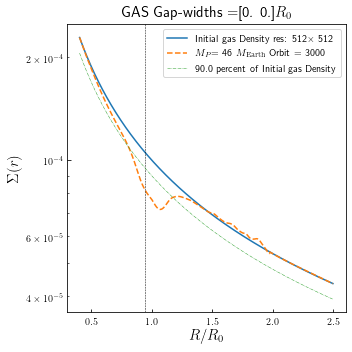

(array([0., 0.]), 0, array([0.]))

In [6]:
V._get_the_disk_gap(fluid,fluid_property,fraction=0.9,output=None,gap_type="Dong",plot=True)

currently plotting output=  150
Using Dong Gap Formula


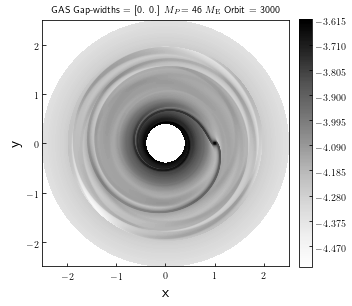

In [7]:
# V._density_plot(fluid,fluid_property)
# V._movie_density_plot(fluid,fluid_property,plot_type="2D_polar",frequency=10,Parallel=None)
# V._movie_density_plot(fluid,fluid_property,frequency=10,Parallel=True)
# V._get_the_disk_gap(fluid,fluid_property,output=50)
V._density_plot(fluid,fluid_property,plot_type="2D_polar",output=None,gap_type="Dong",fraction=0.05)
# V._density_plot(fluid,fluid_property,plot_type="1D",output=None,gap_type="Dong",fraction=0.09)
# V._density_plot(fluid,fluid_property,plot_type="2D_polar",output=10)
# V._time_evol_disk_gap(fluid,fluid_property,fraction=0.5,frequency=10)
#         

# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,4))
# V._density_plot(fluid,fluid_property,plot_type="2D_polar",output=150,ax=ax1)
# V._density_plot(fluid,fluid_property,plot_type="2D_polar",output=10,ax=ax2)
# V.run()
# V.do_something(10)

In [8]:
V._time_evol_disk_gap(fluid,fluid_property,fraction=0.9,gap_type="Dong",frequency=1)
# V._params

Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong 

Dong
2D_polar
Plotting now...
currently plotting output=  0
currently plotting output=  10
currently plotting output=  20
currently plotting output=  30
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula


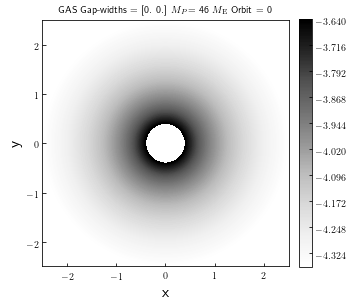

currently plotting output=  40


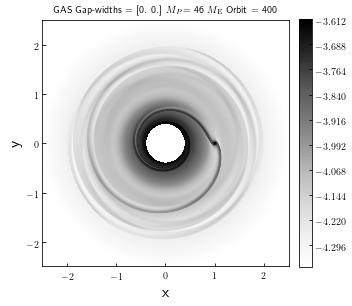

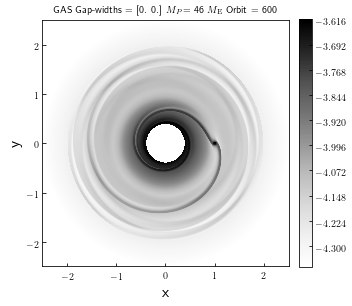

currently plotting output=  50
currently plotting output=  60


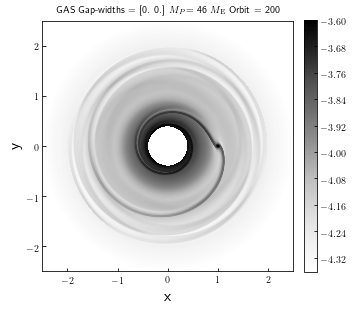

currently plotting output=  70
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula


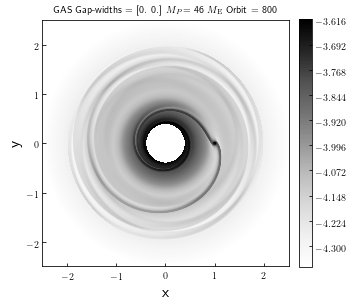

currently plotting output=  80


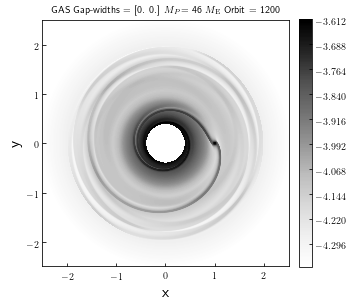

currently plotting output=  90


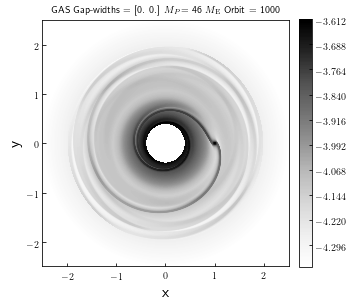

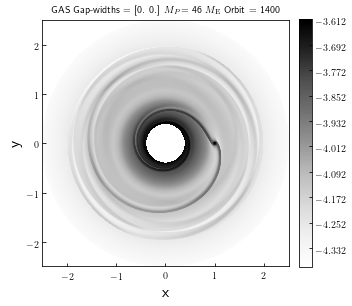

currently plotting output=  100
currently plotting output=  110
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula


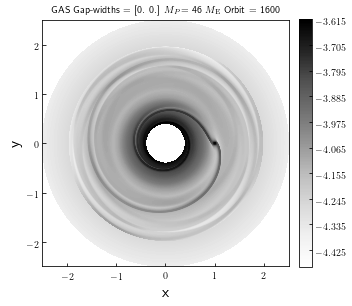

currently plotting output=  120


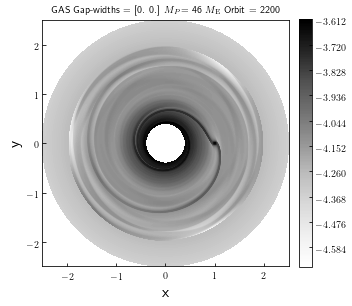

currently plotting output=  130


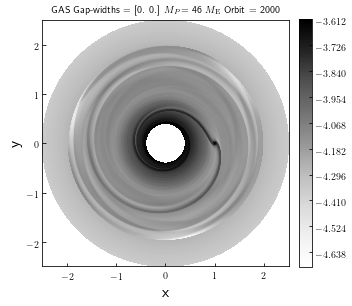

currently plotting output=  140


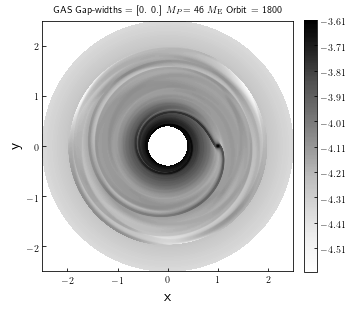

currently plotting output=  150
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula
Using Dong Gap Formula


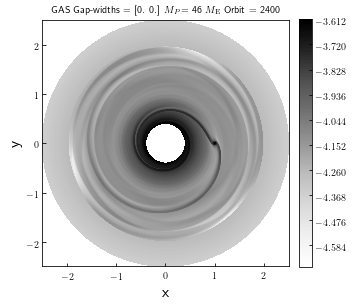

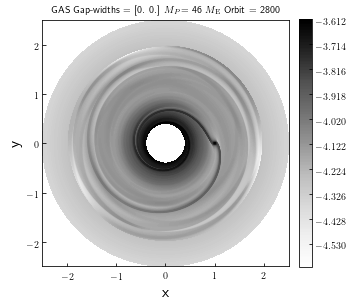

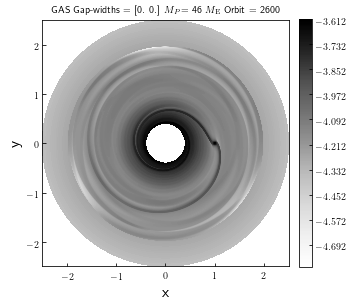

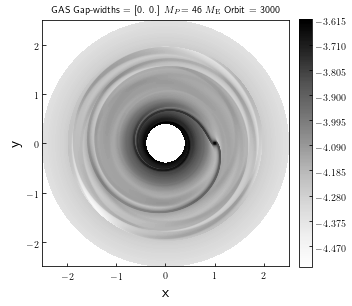

End of simulation
Total time for Parallel run 17.78 sec


In [9]:
# V._movie_density_plot(fluid_list[0],fluid_property)
V._time_lapse(fluid,fluid_property,plot_type="2D_polar",gap_type="Dong",Parallel=True)

In [10]:
# def create_subplot(data, ax=None):
#     if ax is None:
#         ax = plt.gca()
#     more_data = data*2  
#     bp = ax.boxplot(more_data)
#     ax.set_title('Combined debt growth over time')
#     return bp
# data=np.linspace(0,1,10)
# # make figure with subplots
# f, [(ax1, ax2,ax3),(ax4, ax5,ax6)] = plt.subplots(2, 3, sharey=True,sharex=True,figsize=(10,5))

# create_subplot(data, ax1)
# create_subplot(data*2, ax2)
# create_subplot(data*2, ax3)
# create_subplot(data, ax4)
# create_subplot(data*2, ax5)
# create_subplot(data*2, ax6)


In [11]:
# import multiprocessing as mp
# import time
# from time import sleep
# import concurrent.futures
# class A(object):
#     def __init__(self, *args, **kwargs):
#         # do other stuff
#         pass
# #     start = time.perf_counter()  
#     def do_something(self, seconds,minutes=None):
# #         print(kwargs['minutes'])
#         print(f'Sleeping {seconds} seconds...{minutes}')
#         time.sleep(seconds)
    
#     def run(self):
            
#         with concurrent.futures.ProcessPoolExecutor() as executor:   
#             secs = [5,4,3,2,1]
#             number = '2'
#             minutes = repeat(number,len(secs))
# #             minutes =2 
#             results = executor.map(self.do_something, secs,minutes)    

